### Analysis software development v2 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
import lmfit as lm

# import data handling class
from DT5550 import *
from scipy.special import legendre

# %load_ext snakeviz

Open a datafile and read the data

In [37]:
#
# open the datfile / data directory
#
    
#io = DT5550(indir='C:/data/20220112_105851/')
#io = DT5550(file='C:/data/20220110_165917/data_20220110_165917_24.raw')

#
# loop over all the events
#
dt_max = 5

Etot = []
Etot_sel = []
nhit_tag1173 = np.zeros(8)
nhit_tag1330 = np.zeros(8)
nhit_untag1173 = np.zeros(8)
nhit_untag1330 = np.zeros(8)

ee = []
ee_1173 = []
ee_1330 = []
for i in range(8):
    ee.append([])
    ee_1173.append([])
    ee_1330.append([])


nmax = 9999
nf = 0
idet_old = 0

# untagged
#io = DT5550(indir='C:/data/20220112_105851/')
#
#for file in io.filenames:
#    io.open_data(file)
#    nf = nf + 1
#    if nf>nmax:
#        break
#    while io.read_event() == 0:
#        #
#        # data: io.Q[0:ndet-1] -> energy
#        #       io.ph[0:ndet-1] -> peak height
#        #       io.t[0:ndet-1] -> time without timewalk correction
#        #       io.tc[0:ndet-1] -> time with timewalk correction
#        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
#        #       io.R[0:ndet-1] -> peak/area ratio
#        
#        nh = io.valid.sum()
#        
#        # events with one or more hits
#        if nh == 1:
#            for idet in range(8):                
#                rr = io.R[idet]
#                rmean = io.config['detector_settings'][idet]['RMEAN']
#                rsig = io.config['detector_settings'][idet]['RSIGMA']
#                if io.valid[idet]:
#                    ee[idet].append(io.Q[idet])
#             
#                if io.valid[idet] and io.Q[idet]>1100 and io.Q[idet]<1250: #and abs(rr-rmean)<2*rsig:
#                    nhit_untag1173[idet] += 1
#                if io.valid[idet] and io.Q[idet]>1250 and io.Q[idet]<1450: #and abs(rr-rmean)<2*rsig:
#                    nhit_untag1330[idet] += 1
#
#print('Processing done')

# tagged
io = DT5550(indir='C:/data/20220110_165917/')
nf = 0

for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0:   
        nh = io.valid.sum()

        # events with two hits
        if nh == 2:
            id_sel = []
            for idet in range(8):
                if io.valid[idet]:
                    id_sel.append(idet)
                    
            id0 = id_sel[0]
            id1 = id_sel[1]
            #  the total measured energy
            Etot.append(io.Q.sum()) 
            
            delta_t = io.tc[id1] - io.tc[id0]
            if id0 == 0:
                if abs(delta_t) < dt_max:
                    Esum = io.Q[id0] + io.Q[id1]
                    Etot_sel.append(Esum)
                    if io.Q[id0]>1250 and io.Q[id0]<1450:
                        ee_1173[id1].append(io.Q[id1])
                        if io.Q[id1]>1100 and io.Q[id1]<1250:
                            nhit_tag1173[id1] += 1
                    if io.Q[id0]>1100 and io.Q[id0]<1250:
                        ee_1330[id1].append(io.Q[id1])
                        if io.Q[id1]>1250 and io.Q[id1]<1450:
                            nhit_tag1330[id1] += 1
                

print('Processing done')

Etot = np.array(Etot,dtype=object)
Etot_sel = np.array(Etot_sel,dtype=object)
ee = np.array(ee,dtype=object)
ee_1173 = np.array(ee_1173,dtype=object)
ee_1330 = np.array(ee_1330,dtype=object)

#r = np.array(r, dtype=object)

DT5550:: Data recorded with config:  C:/data/20220110_165917\config_20220110_165917.json
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_0.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_1.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_2.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_3.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_4.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_5.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_6.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_7.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_8.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_9.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_10.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_11.r

In [3]:
#io.plot_all(type="charge",bins=50,logy=False, range=(1000,1500))

In [4]:
#io.plot_all(type="time",range=(0,250),bins=100,logy=True)

In [84]:
from scipy.optimize import curve_fit

def legendre_polynomial(x, a, b, c):
    p = [a, b, c]
    
    P0 = legendre(0)
    P2 = legendre(2)
    P4 = legendre(4)
    
    return p[0]*(P0(x) + p[1]*P2(x) + p[2]*P4(x))

def legendre_fit(x, y, yerr, **kwargs):
    """
    Fit Legendre polynomials
    """
    p0 = [12000, 0.1, 0.001]
    
    fit_par, _ = curve_fit(legendre_polynomial, x, y, sigma=yerr, p0=p0)

    return fit_par

def gauss_C(x, a, b, c):
    p = [a,b,c]
    return p[1] * ( np.exp(-((x - p[0]) / p[2]) ** 2 / 2))

def gauss_fit(data, **kwargs):
    """
    Fit a Gaussian to a distribution
    """
    p0 = kwargs.pop('p0', (1, 1, 1))
    fit_range = kwargs.pop('range', (0, 3000))
    bins = kwargs.pop('bins', 100)

    data = data[data>fit_range[0]]
    data = data[data<fit_range[1]]

    # fit a Gaussian to the delta_t distribution
    y, xe = np.histogram(data, bins=bins, range=fit_range)
    x = .5 * (xe[:-1] + xe[1:])

    # Fit the data with the function
    fit_par, fit_cov = curve_fit(gauss_C, x, y, p0=p0)

    return fit_par, fit_cov

IDET =  1
1  N1173= 24705.06148868099  D= 420.80537549922565  Dsqrt = 157.1784383707924
1  N1330= 24754.736761978325  D= 341.57691820339033
IDET =  2
2  N1173= 24708.502582552337  D= 318.55570105892593  Dsqrt = 157.18938444612706
2  N1330= 24512.862785913516  D= 388.3111258078876
IDET =  3
3  N1173= 23149.040245061344  D= 351.79925054496346  Dsqrt = 152.14808656391753
3  N1330= 23449.40413903521  D= 335.0607347923597
IDET =  4
4  N1173= 23184.644347592643  D= 589.8162433079106  Dsqrt = 152.26504637503857
4  N1330= 22598.096999214325  D= 364.71025497975745
IDET =  5
5  N1173= 21630.156662625282  D= 425.88692065500265  Dsqrt = 147.07194383234787
5  N1330= 21424.2335812579  D= 303.45258195652406
IDET =  6
6  N1173= 22036.670987501027  D= 354.8330895188548  Dsqrt = 148.44753614493246
6  N1330= 21317.385928127067  D= 244.84127738734693
IDET =  7
7  N1173= 21075.970837972676  D= 420.9696298924989  Dsqrt = 145.1756551146668
7  N1330= 20857.939270307175  D= 269.91899982404175


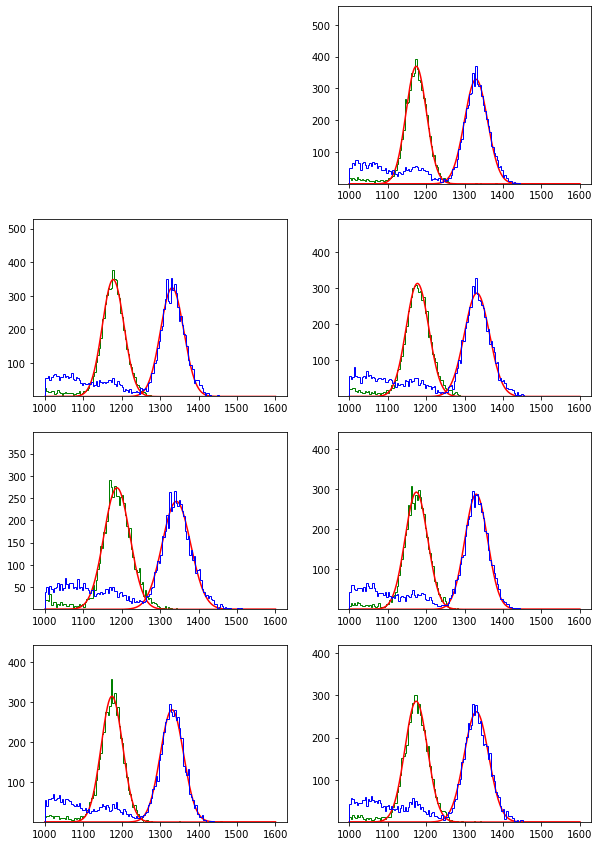

In [107]:
plot_range = (1000, 1600)
fit_range1173 = (1100, 1250)
fit_range1330 = (1250, 1500)

bins = 150
bin_width = (plot_range[1] - plot_range[0])/bins
xx = np.linspace(plot_range[0],plot_range[1],1000)


n_tag1173 = np.zeros(8)
dn_tag1173 = np.zeros(8)

n_tag1330 = np.zeros(8)
dn_tag1330 = np.zeros(8)

s2p = np.sqrt(2*np.pi)

plt.figure(figsize=(10,15))
for idet in range(1,8):
    print('IDET = ',idet)
    plt.subplot(4, 2, 1+idet)

    # 1173keV
    data = np.array(ee_1173[idet])
    fit, cov = gauss_fit(data, range=fit_range1173, bins=int((fit_range1173[1]-fit_range1173[0])/bin_width), p0=(1173, 1000, 20))
    h = plt.hist(data, bins=bins, range=plot_range, histtype='step', color='green')
    plt.plot(xx, gauss_C(xx, fit[0], fit[1], fit[2]),color='red')
    n_tag1173[idet] = fit[1]*fit[2]*s2p
    vec = np.array([0, fit[2]*s2p, fit[1]*s2p])
    #print('V',vec)
    #print('C',cov)
    dn_tag1173[idet] = np.sqrt(np.dot(vec, np.dot(cov, vec)))
    print(idet,' N1173=',n_tag1173[idet], ' D=',dn_tag1173[idet],' Dsqrt =',np.sqrt(n_tag1173[idet]))
    
    # 1332keV
    data = np.array(ee_1330[idet])
    #data = data[data>2400]
    fit, cov = gauss_fit(data, range=fit_range1330, bins=int((fit_range1330[1]-fit_range1330[0])/bin_width), p0=(1330, 1000, 20))
    plt.plot(xx, gauss_C(xx, fit[0], fit[1], fit[2]),color='red')
    y,_,_ = plt.hist(data, bins=bins, range=plot_range, histtype='step', color='blue')

    n_tag1330[idet] = fit[1]*fit[2]*s2p
    vec = np.array([0, fit[2]*s2p, fit[1]*s2p])
    dn_tag1330[idet] = np.sqrt(np.dot(vec, np.dot(cov,vec)))
    print(idet,' N1330=',n_tag1330[idet], ' D=',dn_tag1330[idet])


    plt.yscale('linear')
    plt.ylim([0.6,1.5*max(y)])

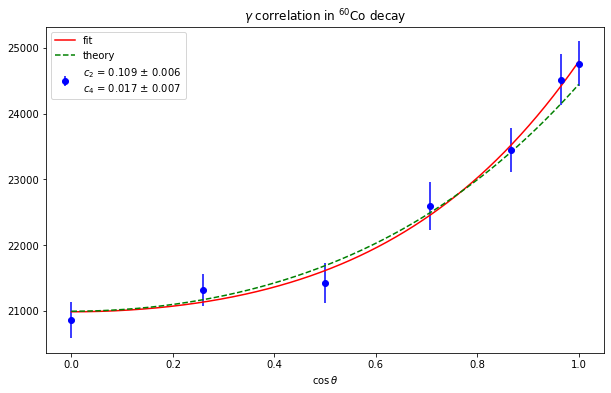

In [106]:

x = np.arange(1,8,1)
theta = (7-x)*(np.pi/12)+np.pi/2
cost = abs(np.cos(theta))

#data = n_tag1173[1:8]
data = n_tag1330[1:8]
#data = n_tag[1:8]
#data = nhit_tag1173[1:8]

#corr = (nhit_untag1173[1:8]+nhit_untag1330[1:8])
#corr = nhit_untag1330[1:8]
corr = np.ones(7)
y =  data / corr
yerr = dn_tag1330[1:8] / corr
#
# fit the data
#
fit = legendre_fit(cost, data, yerr=yerr)
#
# plot the data
#
txt = '$c_2$ = {:4.3f} $\pm$ {:4.3f} \n$c_4$ = {:4.3f} $\pm$ {:4.3f}'.format(b,b_err,c,c_err)
plt.figure(figsize=(10,6))
h = plt.errorbar(cost, y, yerr=yerr, fmt = 'o', color='blue', label=txt)
#
# plot the fit to the data
#
xx = np.linspace(0,1,500)
plt.plot(xx, legendre_polynomial(xx, fit[0], fit[1], fit[2]),'-',color='red', label='fit')
plt.plot(xx, legendre_polynomial(xx, fit[0], 0.1005, 0.0094), '--', color='green', label='theory' )
plt.xlabel('$\cos \\theta$')
plt.legend()
plt.title("$\gamma$ correlation in $^{60}$Co decay")

plt.show()